In [2]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import linregress, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf

import geopandas as gpd
import networkx as nx
import math

In [3]:



def scaling_iloc(x0,y0,name):
    # print(len(x0))
    samis = Get_SAMIs(x0,y0)
    # print("SAMIs = ",samis)
    # print("Var = ",np.round(np.var(samis),2))
    x = np.log(x0)
    Y = np.log(y0)
    X = sm.add_constant(x)
    model = sm.OLS(Y,X)
    fit = model.fit(cov_type='HC1')
    # print(fit.summary())
        
    intercept, slope = fit.params
    # print("intercept = ", np.round(intercept,2))
    # print("c = ", np.round(np.exp(intercept),3))

    x_0 =  np.sort(x0)[0]
    y_0 = np.exp(slope*np.log(x_0)+intercept)

    x_f = np.sort(x0)[-1]
    y_f = np.exp(slope*np.log(x_f)+intercept)
    y_null = np.exp(np.log(x_f)+intercept)

    betta = round(slope,3)
    R2 = str(round(fit.rsquared,2))
    # print(R2)
    # R2 = str(round(fit.pvalues[1],3))
    beta_lowerbound, beta_upper = fit.conf_int().iloc[1]
    beta_lowerbound = np.round(beta_lowerbound,2)
    beta_upper = np.round(beta_upper,2)
    return fit.conf_int().iloc[1,:],samis,betta,float(R2)

def Get_SAMIs(x0,y0):
    x = np.log(x0)
    y = np.log(y0)
    res = linregress(x,y)
    y_hat = res.intercept + res.slope*x
    SAMIs = y-y_hat
    return SAMIs


def all_upper(my_list): 
    return list(map(lambda x: x.upper(), my_list))

def getGini( percapita):

    mad = np.abs(np.subtract.outer(percapita, percapita)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(percapita)
    # Gini coefficient
    G = 0.5 * rmad
    # print(G)
    return G

def scaling_weighted(x0,y0,name):
    # print(len(x0))
    samis = Get_SAMIs(x0,y0)
    # print("SAMIs = ",samis)
    # print("Var = ",np.round(np.var(samis),2))
    x = np.log(x0)
    Y = np.log(y0)
    
    errors = Y - np.mean(Y)
    error_variance = np.var(errors)
    weights = 1/error_variance

    X = sm.add_constant(x)
    model = sm.WLS(Y,X, weights=error_variance)
    fit = model.fit(cov_type='HC1')
    # print(fit.summary())
        
    intercept, slope = fit.params
    # print("intercept = ", np.round(intercept,2))
    # print("c = ", np.round(np.exp(intercept),3))

    x_0 =  np.sort(x0)[0]
    y_0 = np.exp(slope*np.log(x_0)+intercept)

    x_f = np.sort(x0)[-1]
    y_f = np.exp(slope*np.log(x_f)+intercept)
    y_null = np.exp(np.log(x_f)+intercept)

    betta = round(slope,3)
    R2 = str(round(fit.rsquared,2))
    # print(R2)
    # R2 = str(round(fit.pvalues[1],3))
    beta_lowerbound, beta_upper = fit.conf_int().iloc[1]
    beta_lowerbound = np.round(beta_lowerbound,2)
    beta_upper = np.round(beta_upper,2)


    return fit.conf_int().iloc[1,:],samis,betta,float(R2)


def Compute_Gini(Y):
    T_plus = np.sum(Y[Y>0])
    T_minus = -np.sum(Y[Y<0])
    delta = 0
    N = len(Y)
    for i in range(N):
        for j in range(N):
            delta += np.abs(Y.iloc[i]-Y.iloc[j])
    delta = delta/(2*N**2)
    mu_p = ((N-1)/N**2)*(T_plus+T_minus)
    return delta/mu_p

In [4]:
groupedict = { 
               "DERMATOLOGY":['MICROGRAPHIC DERMATOLOGIC SURGERY (MDS)'],
               "EMERGENCY MEDICINE":[
                                    'SPORTS MEDICINE',
                                    # 'PAIN MANAGEMENT',
                                    'HOSPICE/PALLIATIVE CARE',
                                    'CRITICAL CARE (INTENSIVISTS)',

                                    'PHYSICIAN ASSISTANT'],
               "FAMILY PRACTICE":[
                                  'SPORTS MEDICINE',
                                  # 'PAIN MANAGEMENT',
                                  'SLEEP MEDICINE',
                                  'HOSPICE/PALLIATIVE CARE',
                                  'GERIATRIC MEDICINE',
                                  'PHYSICIAN ASSISTANT', 
                                #   'GENERAL PRACTICE',
                                  'CERTIFIED CLINICAL NURSE SPECIALIST (CNS)',
                                  ],

               "NURSE PRACTITIONER":[
                                  'CERTIFIED CLINICAL NURSE SPECIALIST (CNS)',
                                  'CERTIFIED NURSE MIDWIFE (CNM)',
                                  'CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)',

                   
                                  ],
               "INTERNAL MEDICINE":[
                                    'SPORTS MEDICINE',
                                    'SLEEP MEDICINE',
                                    'RHEUMATOLOGY',
                                    'PULMONARY DISEASE',
                                    'NEPHROLOGY',
                                    'MEDICAL ONCOLOGY',
                                    'HEMATOLOGY',
                                    'HOSPICE/PALLIATIVE CARE', 
                                    'GASTROENTEROLOGY', 
                                    'GERIATRIC MEDICINE',
                                    'ENDOCRINOLOGY',
                                    'CRITICAL CARE (INTENSIVISTS)',
                                    'CARDIOVASCULAR DISEASE (CARDIOLOGY)', 
                                    'CARDIAC ELECTROPHYSIOLOGY',
                                    'INTERVENTIONAL CARDIOLOGY',
                                    'INFECTIOUS DISEASE',
                                    'ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY',
                                    ],
               
               "OBSTETRICS/GYNECOLOGY":[
                                    'CRITICAL CARE (INTENSIVISTS)',
                                    'GYNECOLOGICAL ONCOLOGY',
                                    'ENDOCRINOLOGY',
                                    'CERTIFIED NURSE MIDWIFE (CNM)',
                                    'HOSPICE/PALLIATIVE CARE',
                                    ],
               "MEDICAL ONCOLOGY":['GYNECOLOGICAL ONCOLOGY','SURGICAL ONCOLOGY', 'HEMATOLOGY/ONCOLOGY'],
               "OPHTHALMOLOGY":[
                                    # 'OPTOMETRY'
                                    ],
               'OPTOMETRY':[],
               "ORTHOPEDIC SURGERY":[
                                    'HAND SURGERY',
                                    'PODIATRY',
                                    'SPORTS MEDICINE',
                                    
                                    ],
               "OTOLARYNGOLOGY":[
                                    "MAXILLOFACIAL SURGERY", 
                                    "ORAL SURGERY",
                                    "QUALIFIED AUDIOLOGIST",
                                    "SLEEP MEDICINE",
                                    "PLASTIC AND RECONSTRUCTIVE SURGERY",
                                    ],
               "PATHOLOGY":[
                                    "QUALIFIED SPEECH LANGUAGE PATHOLOGIST",
                                    "HEMATOLOGY",
                                    ],
               "PEDIATRIC MEDICINE":[
                                    "SLEEP MEDICINE",
                                    "SPORTS MEDICINE",
               ],
               "PHYSICAL MEDICINE AND REHABILITATION":[
                                    "PHYSICAL THERAPY",
                                    'HOSPICE/PALLIATIVE CARE',
                                    "OCCUPATIONAL THERAPY", 
                                    "PAIN MANAGEMENT",
                                    "SPORTS MEDICINE",
                                    ],
               "PAIN MANAGEMENT":['INTERVENTIONAL PAIN MANAGEMENT'],
               "PLASTIC AND RECONSTRUCTIVE SURGERY":["HAND SURGERY"],
               "PREVENTIVE MEDICINE":["ADDICTION MEDICINE"],
               "PSYCHIATRY":[
                                    "CLINICAL PSYCHOLOGIST",
                                    "PAIN MANAGEMENT",
                                    "SLEEP MEDICINE",
                                    ],
               "NEUROLOGY":[        
                                    "NEUROSURGERY",
                                    "CLINICAL PSYCHOLOGIST",
                                    "PAIN MANAGEMENT",
                                    "SLEEP MEDICINE",
                                    ],
               "GENERAL PRACTICE":["VASCULAR SURGERY",
                                   "GENERAL SURGERY", 
                                   "SURGICAL ONCOLOGY"],
               "GENERAL SURGERY":[
                                  "HAND SURGERY",
                                  "SURGICAL ONCOLOGY",
                                  "COLORECTAL SURGERY (PROCTOLOGY)",
                                  "VASCULAR SURGERY",
                                  'CARDIAC SURGERY',
                                  'PLASTIC AND RECONSTRUCTIVE SURGERY',
                                  'THORACIC SURGERY',
                                  ],
               "VASCULAR SURGERY":["HAND SURGERY",
                                  "SURGICAL ONCOLOGY"],
               "INTERVENTIONAL RADIOLOGY":[
                                    "NUCLEAR MEDICINE",
                                    "PAIN MANAGEMENT"], 
               "DIAGNOSTIC RADIOLOGY":[
                                    "NUCLEAR MEDICINE",
                                    "PAIN MANAGEMENT",
                                    "INTERVENTIONAL RADIOLOGY",
                                    
               ], 
               "RADIATION ONCOLOGY":[
                                    # "PAIN MANAGEMENT",
                                    'HOSPICE/PALLIATIVE CARE',
               ],

               "ANESTHESIOLOGY":["ANESTHESIOLOGY ASSISTANT", 
                                 "CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA)",
                                 'CRITICAL CARE (INTENSIVISTS)',
                                 'PAIN MANAGEMENT',
                                 "SLEEP MEDICINE", 
                                 "HOSPICE/PALLIATIVE CARE"],
               "ALLERGY/IMMUNOLOGY":["REGISTERED DIETITIAN OR NUTRITION PROFESSIONAL"],
            #    "SPORTS MEDICINE":["PHYSICAL THERAPY"],
               "SPORTS MEDICINE":[],
               'CARDIOVASCULAR DISEASE (CARDIOLOGY)':['CARDIAC ELECTROPHYSIOLOGY','CARDIAC SURGERY','INTERVENTIONAL CARDIOLOGY'],
               'HEMATOLOGY':['HEMATOLOGY/ONCOLOGY'],
               "OCCUPATIONAL THERAPY":["CHIROPRACTIC","OSTEOPATHIC MANIPULATIVE MEDICINE"],
               "CLINICAL PSYCHOLOGIST":["MARRIAGE AND FAMILY THERAPIST","MENTAL HEALTH COUNSELOR","CLINICAL SOCIAL WORKER"],
               
               'CARDIAC SURGERY':['ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY'],
               'PODIATRY':["PHYSICAL MEDICINE AND REHABILITATION"],
               "THORACIC SURGERY":['CARDIAC SURGERY'],
               "UROLOGY":[],
               "COLORECTAL SURGERY (PROCTOLOGY)":[],
               'NUCLEAR MEDICINE':[],
               }

### Hierarchical network measure

In [5]:


G = nx.DiGraph()

for node, neighbors in groupedict.items():
    G.add_node(node)
    for n in neighbors:
        G.add_node(n)
        G.add_edge(node, n)

CE_positive = np.zeros((len(G.nodes), len(G.nodes)), dtype=float)
CE_negative = np.zeros((len(G.nodes), len(G.nodes)), dtype=float)

D_out = np.zeros((len(G.nodes), len(G.nodes)), dtype=float)

for i in range(len(G.nodes())):
    for j in range(len(G.nodes())):
        src = list(G.nodes())[i]
        tgt = list(G.nodes())[j]
        if src != tgt:
            Eij_positive = np.sum([math.prod([1/G.in_degree(v) for v in p[1:]]) for p in nx.all_simple_paths(G, src, tgt)])
            dij = [1/((len(p)-1)) for p in nx.all_simple_paths(G, src, tgt)]
            D_out[i,j] = np.sum(dij)
            Eij_negative = np.sum([math.prod([1/G.out_degree(v) for v in p[:-1]]) for p in nx.all_simple_paths(G, tgt, src)])
            
            # print(Eij_positive, Eij_negative)
            CE_positive[i,j] = Eij_positive
            CE_negative[i,j] = Eij_negative

eta = np.sum(CE_positive-CE_negative, axis=1)
mu = np.sum(CE_positive-CE_negative, axis=0)

            

df_analysis = pd.DataFrame({
    'Specialty': nx.pagerank(G).keys(),
    'PageRank': nx.pagerank(G).values(),
    'katz_centrality': nx.katz_centrality(G).values(),
    'in_degree_centrality': nx.in_degree_centrality(G).values(),
    'out_degree_centrality': nx.out_degree_centrality(G).values(),
    'local_reaching_centrality': [nx.local_reaching_centrality(G, v) for v in G.nodes()],
    # 'global_reaching_centrality': nx.global_reaching_centrality(G).values(),
})

df_analysis['eta'] = eta
df_analysis['mu'] = mu

df_analysis['CE_positive'] = np.sum(CE_positive, axis=1)
df_analysis['CE_negative'] = np.sum(CE_negative, axis=1)

df_analysis['new_reaching'] = np.sum(D_out, axis=1)/(len(G.nodes)-1)
# df_analysis = df.merge(df_analysis, on='Specialty')
df_analysis


,Specialty,PageRank,katz_centrality,in_degree_centrality,out_degree_centrality,local_reaching_centrality,eta,mu,CE_positive,CE_negative,new_reaching
0,DERMATOLOGY,0.009207,0.099984,0.000000,0.013514,0.013514,1.000000,-1.000000,1.000000,0.000000,0.013514
1,MICROGRAPHIC DERMATOLOGIC SURGERY (MDS),0.017033,0.109982,0.013514,0.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,0.000000
2,EMERGENCY MEDICINE,0.009207,0.099984,0.000000,0.054054,0.054054,1.059524,-1.000000,1.059524,0.000000,0.054054
3,SPORTS MEDICINE,0.022722,0.161074,0.081081,0.000000,0.000000,-1.775490,1.333333,0.000000,1.775490,0.000000
4,HOSPICE/PALLIATIVE CARE,0.026896,0.171072,0.094595,0.000000,0.000000,-2.308824,1.285714,0.000000,2.308824,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
70,OSTEOPATHIC MANIPULATIVE MEDICINE,0.014511,0.111092,0.013514,0.000000,0.000000,-0.733333,4.000000,0.000000,0.733333,0.000000
71,MARRIAGE AND FAMILY THERAPIST,0.013109,0.111982,0.013514,0.000000,0.000000,-0.527778,2.000000,0.000000,0.527778,0.000000
72,MENTAL HEALTH COUNSELOR,0.013109,0.111982,0.013514,0.000000,0.000000,-0.527778,2.000000,0.000000,0.527778,0.000000
73,CLINICAL SOCIAL WORKER,0.013109,0.111982,0.013514,0.000000,0.000000,-0.527778,2.000000,0.000000,0.527778,0.000000


### visualization of medical intra-specialty network

In [7]:
links = []

for specialty, subspecialties in groupedict.items():
    for subspecialty in subspecialties:
        links.append({"source": specialty, "target": subspecialty, "value": 1})


nodes = list(set([link["source"] for link in links] + [link["target"] for link in links]))

node_map = {node: idx for idx, node in enumerate(nodes)}

sankey_links = {
    "source": [node_map[link["source"]] for link in links],
    "target": [node_map[link["target"]] for link in links],
    "value": [link["value"] for link in links],
}


fig = go.Figure(
    go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=nodes,
            color=["skyblue" if node in specialty else "lightblue" for node in nodes],
        ),
        link=sankey_links,
    )
)

fig.update_layout(
    #title_text="Specialties and Subspecialties - Sankey Diagram",
    font_size=10,
    width = 1000,
    height=1000,  # Increase height for larger datasets
)
# fig.savefig('doctorNetwork.pdf', dpi=300)
fig.show()


In [8]:
CountBySpecialty = pd.read_csv('./CountBySpecialty.csv')
CountBySpecialty['PerCapita'] = CountBySpecialty['Count']/CountBySpecialty['msa_pop']
CountBySpecialty.head()

,Unnamed: 0,cbsa,msa_name,msa_pop,LSAD,Specialty,Count,PerCapita
0,0,10100.0,"Aberdeen, SD",41790,Micropolitan Statistical Area,PATHOLOGY,2,0.000048
1,1,10140.0,"Aberdeen, WA",77290,Micropolitan Statistical Area,PATHOLOGY,2,0.000026
2,2,10180.0,"Abilene, TX",181591,Metropolitan Statistical Area,PATHOLOGY,4,0.000022
3,3,10220.0,"Ada, OK",38396,Micropolitan Statistical Area,PATHOLOGY,2,0.000052
4,4,10300.0,"Adrian, MI",97520,Micropolitan Statistical Area,PATHOLOGY,11,0.000113


In [9]:
cbsacode = CountBySpecialty.cbsa.unique()
Specialty = CountBySpecialty.Specialty.unique()
new_df = pd.DataFrame({
    'cbsacode':cbsacode,
    # 'Specialty':[],
    # 'Specialty_Count':[],
})
for s in Specialty:
    new_df[s] = np.nan

for c in cbsacode:
    for s in Specialty:
        try:
            sc = CountBySpecialty[(CountBySpecialty['cbsa']==c)&(CountBySpecialty['Specialty']==s)]['Count'].iloc[0]
            new_df.loc[new_df['cbsacode'] == c, s] = sc
        except:
            new_df.loc[new_df['cbsacode'] == c, s] = 0
            
new_df

,cbsacode,PATHOLOGY,CERTIFIED REGISTERED NURSE ANESTHETIST (CRNA),GYNECOLOGICAL ONCOLOGY,EMERGENCY MEDICINE,HOSPITALIST,FAMILY PRACTICE,OBSTETRICS/GYNECOLOGY,PHYSICIAN ASSISTANT,GENERAL PRACTICE,...,MEDICAL TOXICOLOGY,ADULT CONGENITAL HEART DISEASE (ACHD),UNDEFINED NON-PHYSICIAN TYPE (SPECIFY),PERIPHERAL VASCULAR DISEASE,ORAL AND MAXILLOFACIAL RADIOLOGY,DENTAL ANESTHESIOLOGY,PROSTHODONTICS,ORAL MEDICINE,ORAL AND MAXILLOFACIAL PATHOLOGY,OROFACIAL PAIN
0,10100.0,2.0,27.0,0.0,4.0,3.0,11.0,7.0,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10140.0,2.0,1.0,0.0,18.0,2.0,19.0,3.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10180.0,4.0,77.0,0.0,24.0,3.0,87.0,15.0,103.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10220.0,2.0,11.0,0.0,34.0,2.0,40.0,9.0,44.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10300.0,11.0,31.0,0.0,3.0,1.0,20.0,4.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,33740.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894,34300.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
895,39700.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
896,42900.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df = pd.read_csv("./Specialty_Count_cbsa.csv")
df_name = pd.read_csv("./new_results_all.csv")
df['DN'] = df.iloc[:, 100:].sum(axis=1)
Dmax = df['DN'].max()

M = len(df)
Cities = []
Ns = []
f_dfs = []
x_dfs = []
for i in range(M):
    N = df.iloc[i]["Population"]
    Cities.append(df.iloc[i]["msa_name"])
    Ns.append(N)
    Fs = df.iloc[i][df_name["Specialty"].values].values
    fs = (-np.sort(-Fs[Fs != 0]))/N
#     fs = (-np.sort(-Fs[Fs != 0]))/np.sum(Fs)
    xs = np.arange(1,len(fs)+1,1)
    f_dfs.append(fs)
    x_dfs.append(xs)


All_xs = np.concatenate(x_dfs)
All_fs = np.concatenate(f_dfs)

x = np.arange(1,76,1) 
f_mean = []
for i in range(1,76):
    f_mean.append(np.mean(All_fs[All_xs==i]))

### Fit for Medical diversity

/var/folders/5r/5gd5nnz10gb73gwmbv5yxjdc0000gp/T/ipykernel_85583/817141622.py:4: RuntimeWarning:

divide by zero encountered in power



[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.11887590e-01  3.32984729e+01 -3.50000000e-01  1.00574845e-03]
[ 7.118875

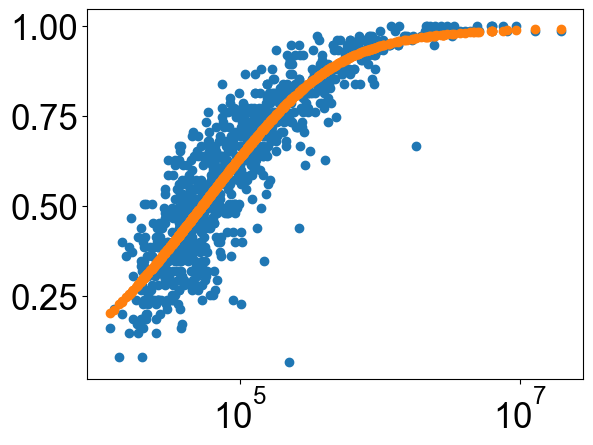

In [11]:
from scipy.optimize import curve_fit, differential_evolution, fsolve

def f(x, gamma, x0, zeta, A, Dmax=75):
    return A * x**(-gamma) * np.exp(-x/x0) * np.exp(1 - (1 - x/Dmax)**zeta)

# def objective(params):
#     gama, x0, zeta, A = params
#     preds = f(All_xs, gama, x0, zeta, A, Dmax=Dmax)
#     return np.sum((preds - All_fs)**2)

def inverse_f(y, params):
    gamma, x0, zeta, A = params
    print(params)
    return fsolve(lambda x: f(x, gamma, x0, zeta, A) - y, x0=1)[0] 

def objective(params):
    gamma, x0, zeta, A = params
    preds = f(x, gamma, x0, zeta, A, Dmax=75)
    return np.sum((preds - f_mean)**2)


bounds = [(0, 10), (0, 70), (-10, -0.35), (0, 10)]

result = differential_evolution(objective, bounds, popsize=100,
                                                        tol=1e-8,
                                                        maxiter=4000,
                                                        polish=True)
Dn_model = []
for n in df["Population"]:
    Dn_model.append(inverse_f(1/n, result.x))

plt.scatter(df["Population"],df["DN"]/Dmax)
plt.scatter(df["Population"],np.array(Dn_model)/Dmax)
plt.xscale("log")
plt.show()